## GNN_DTI Based Learning

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import DataLoader                                     
from gnn import gnn
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import metrics
import utils
from train_tools import *
import os, time, shutil
from IPython.display import clear_output

In [3]:
class Opts: pass

### Options

In [4]:
gnn_opts = Opts()
gnn_opts.n_graph_layer = 4
gnn_opts.d_graph_layer = 140
gnn_opts.n_FC_layer = 4
gnn_opts.d_FC_layer = 128
gnn_opts.initial_mu = 4.46108546619827
gnn_opts.initial_dev = 0.19818493842903845
gnn_opts.dropout_rate = 0.2

In [5]:
learn_opts = Opts()
learn_opts.num_epochs = 1000
learn_opts.lr = 0.0001
learn_opts.batch_size = 64

In [6]:
myopts = Opts()
myopts.data_fpath = 'cbidata'
myopts.save_dir = 'save'
myopts.random_stratify = True
myopts.cache_dir = '/tmp/moldata'
myopts.clear_cache = False              # If you repeat experiments within the same dataset version, set to False
myopts.train_keys = 'keys/keys_refined'
myopts.kinase_list = 'keys/kinase_list'
myopts.dataset_version = 3              # <- The newest is 3, still 1 and 2 are acceptible
myopts.cpu_count = 10

In [7]:
assert myopts.dataset_version in [1, 2, 3]
_ver = myopts.dataset_version
if _ver == 1:
    import dataset as ds
elif _ver == 2:
    import dataset2 as ds
else:
    import dataset3 as ds

### Support functions for learning loop

In [8]:
def learn(model, loader, train=True):
    losses = []
    for sample in loader:
        model.zero_grad()
        H, A1, A2, Y, V, keys, _ = sample
        H, A1, A2, Y, V = H.to(device), A1.to(device), A2.to(device), Y.to(device), V.to(device)

        pred = model.train_model((H, A1, A2, V))

        loss = loss_fn(pred, Y)
        if train:
            loss.backward()
            optimizer.step()
        losses.append(loss.data.cpu().numpy())
    mean_loss = np.mean(np.array(losses))
    return mean_loss

def test(model, loader):
    test_true, test_pred, test_label = [], [], []

    saliency_list = []
    n_atom_list = []

    model.eval()
    for i_batch, sample in enumerate(loader):
        model.zero_grad()
        H, A1, A2, Y, V, keys, n_atom = sample

        embed = model.embede(H)
        model.zero_grad()
        pred = model.test_model((embed, A1, A2, V))

        out = torch.sum(pred)
        embed.retain_grad()
        out.backward()
        saliency = embed.grad.clone()
        saliency *= embed.data.clone()

        test_true.append(Y.data.cpu().numpy())
        test_pred.append(pred.data.cpu().numpy())
        test_label.append(keys)
        saliency_list.append(saliency)
        n_atom_list.append(n_atom)

    test_pred = np.concatenate(np.array(test_pred), 0)
    test_true = np.concatenate(np.array(test_true), 0)
    return test_true, test_pred, test_label, saliency_list, n_atom_list

def get_stats(X, y):
    rmse = metrics.mean_squared_error(X, y)**0.5
    mae = metrics.mean_absolute_error(X, y)
    r2 = stats.pearsonr(X, y)
    rho = stats.spearmanr(X, y)
    return rmse, mae, r2[0], rho[0]

def update_train_loss(train_loss, best_train_loss):
    if train_loss < best_train_loss:
        best_train_loss = train_loss
    return best_train_loss

def update_test_loss(model, opts, test_loss, best_val_loss, epoch):
    output = False
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        output = True
    if output:
        torch.save(model.state_dict(), f'{opts.save_dir}/save_{epoch}.pt')
        torch.save(model.state_dict(), f'{opts.save_dir}/model_weights.pt')
    return best_val_loss, output

### Setup

In [9]:
if myopts.clear_cache:
    try:
        shutil.rmtree(myopts.cache_dir)
    except:
        pass

In [10]:
os.makedirs(myopts.save_dir, exist_ok=True)

train = read_keyfile(myopts.train_keys)
train_keys, test_keys, test2_keys = filter_and_stratify(train, random_stratify=myopts.random_stratify)

write_keys(train_keys, 'train.local.key')
write_keys(test_keys, 'test.local.key')
write_keys(test2_keys, 'test2.local.key')

len(train_keys), len(test_keys), len(test2_keys)

(202, 50, 75)

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [12]:
train_dataset = ds.MolDataset([k for k, v in train_keys], [v for k, v in train_keys], myopts.data_fpath)
test_dataset = ds.MolDataset([k for k, v in train_keys], [v for k, v in test_keys], myopts.data_fpath)
len(train_dataset), len(test_dataset)

(202, 50)

In [13]:
gnn_opts.N_atom_features = train_dataset[0]['H'].shape[1]//2

4btk ... caching


In [14]:
train_dataloader = DataLoader(train_dataset, learn_opts.batch_size, shuffle=True, num_workers=myopts.cpu_count, collate_fn=ds.collate_fn)
test_dataloader = DataLoader(test_dataset, learn_opts.batch_size, shuffle=True, num_workers=myopts.cpu_count, collate_fn=ds.collate_fn)

In [15]:
model = utils.initialize_model(gnn(gnn_opts), device)
print ('number of parameters : ', sum(p.numel() for p in model.parameters() if p.requires_grad))
optimizer = torch.optim.Adam(model.parameters(), lr=learn_opts.lr)
loss_fn = nn.MSELoss()

number of parameters :  214727


### Start Learning

5oq85ut65osl 3vhk  ... caching... caching ... caching
... caching


5vcv ... caching
3e92 ... caching
5am7 ... caching
2baj ... caching
4f09 ... caching
3zxz ... caching
1jsv ... caching
5nk7 ... caching
3hmo ... caching
3pyy ... caching
5os2 ... caching
5i9y ... caching
3roc ... caching
3bgz ... caching
5nk9 ... caching
5ya5 ... caching
4m12 ... caching
4ehz ... caching
1kv1 ... caching
5vo1 ... caching
4clj ... caching3jvs 
... caching
1e1x ... caching
3gcp ... caching
4twp ... caching
5n93 ... caching
3d83 ... caching
5ia3 ... caching
5lvl ... caching
5cas ... caching
5v82 ... caching
3o8p ... caching
4gfm ... caching4eor
 ... caching
5orj ... caching
4wov ... caching
4qp2 ... caching
4asd ... caching
6gzd ... caching
4ag8 ... caching
1q5k ... caching
4f9w ... caching
2xj1 ... caching
5c8n ... caching
2exm ... caching
6guh ... caching
4acc ... caching
5caq ... caching
5nkc ... caching
4bcm ... caching
4gii ... caching
4kao ... caching
4bcn ... caching
5os5 ... caching
5nki ... cachi

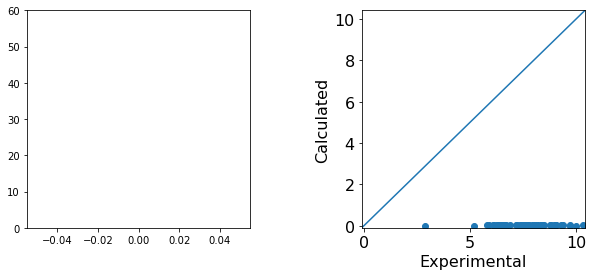

rmse: 7.676, mae: 7.554, r2: 0.150, rho: 0.088
--- Too may off-valued molecules ---

Epoch: 0	Lapse: 15.7s	Losses: (55.997, 58.926)	Best: (55.997, 58.926)


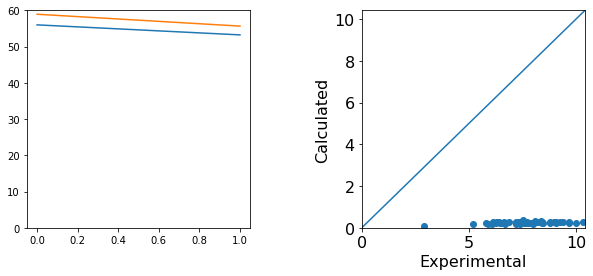

rmse: 7.460, mae: 7.338, r2: 0.400, rho: 0.261
--- Too may off-valued molecules ---

Epoch: 1	Lapse: 4.4s	Losses: (53.233, 55.656)	Best: (53.233, 55.656)


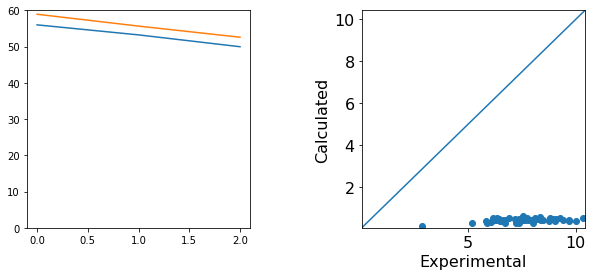

rmse: 7.252, mae: 7.129, r2: 0.422, rho: 0.273
--- Too may off-valued molecules ---

Epoch: 2	Lapse: 5.2s	Losses: (49.965, 52.591)	Best: (49.965, 52.591)


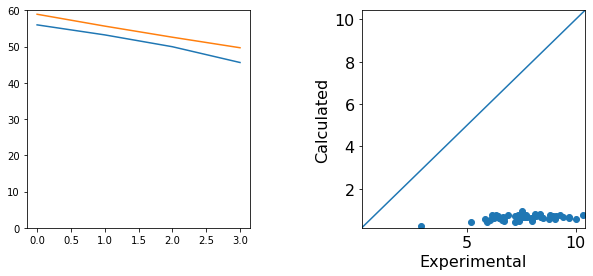

rmse: 7.049, mae: 6.925, r2: 0.430, rho: 0.284
--- Too may off-valued molecules ---

Epoch: 3	Lapse: 5.1s	Losses: (45.612, 49.685)	Best: (45.612, 49.685)


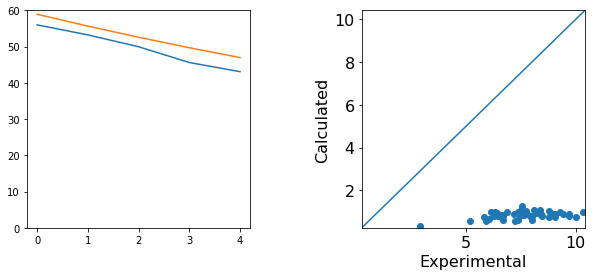

rmse: 6.854, mae: 6.729, r2: 0.431, rho: 0.295
--- Too may off-valued molecules ---

Epoch: 4	Lapse: 4.9s	Losses: (43.081, 46.978)	Best: (43.081, 46.978)


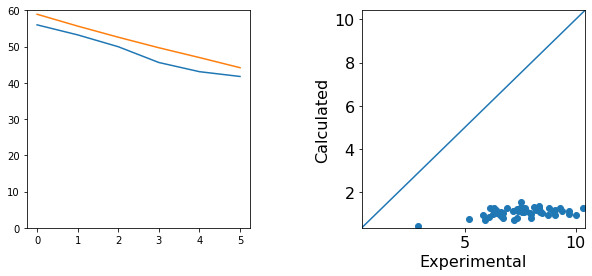

rmse: 6.647, mae: 6.520, r2: 0.433, rho: 0.293
--- Too may off-valued molecules ---

Epoch: 5	Lapse: 5.5s	Losses: (41.758, 44.183)	Best: (41.758, 44.183)


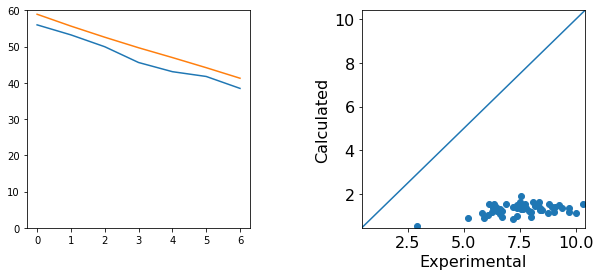

rmse: 6.424, mae: 6.296, r2: 0.433, rho: 0.297
--- Too may off-valued molecules ---

Epoch: 6	Lapse: 4.9s	Losses: (38.469, 41.273)	Best: (38.469, 41.273)


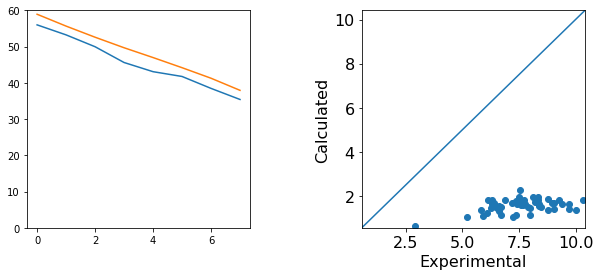

rmse: 6.159, mae: 6.028, r2: 0.437, rho: 0.304
--- Too may off-valued molecules ---

Epoch: 7	Lapse: 5.2s	Losses: (35.411, 37.932)	Best: (35.411, 37.932)


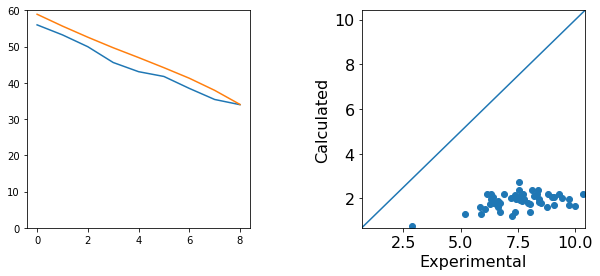

rmse: 5.834, mae: 5.699, r2: 0.442, rho: 0.323
--- Too may off-valued molecules ---

Epoch: 8	Lapse: 5.2s	Losses: (33.972, 34.038)	Best: (33.972, 34.038)


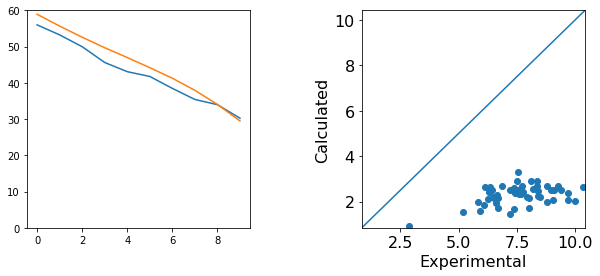

rmse: 5.429, mae: 5.286, r2: 0.446, rho: 0.320
--- Too may off-valued molecules ---

Epoch: 9	Lapse: 5.0s	Losses: (30.229, 29.470)	Best: (30.229, 29.470)


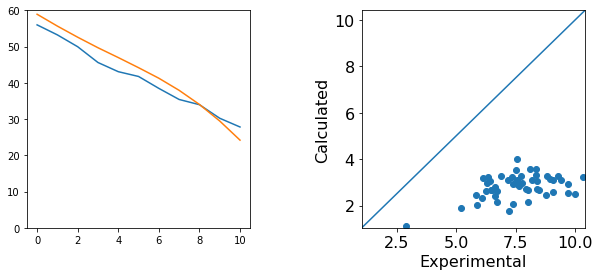

rmse: 4.918, mae: 4.764, r2: 0.452, rho: 0.321
--- Too may off-valued molecules ---

Epoch: 10	Lapse: 5.3s	Losses: (27.818, 24.191)	Best: (27.818, 24.191)


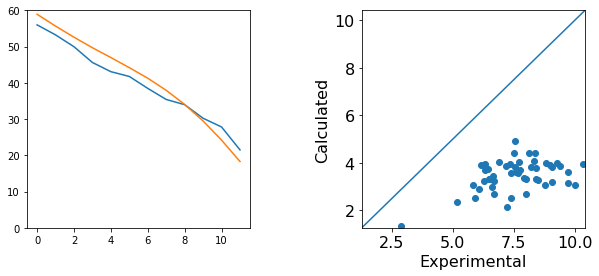

rmse: 4.277, mae: 4.101, r2: 0.456, rho: 0.322
--- Too may off-valued molecules ---

Epoch: 11	Lapse: 4.8s	Losses: (21.502, 18.293)	Best: (21.502, 18.293)


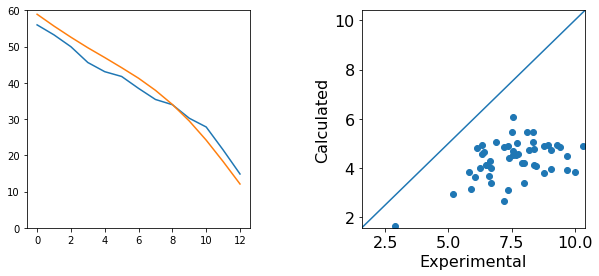

rmse: 3.476, mae: 3.255, r2: 0.462, rho: 0.319
--- Too may off-valued molecules ---

Epoch: 12	Lapse: 5.4s	Losses: (14.845, 12.083)	Best: (14.845, 12.083)


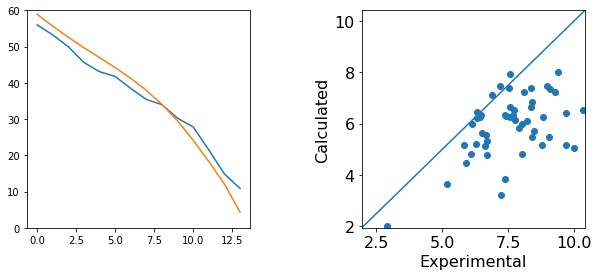

rmse: 2.089, mae: 1.691, r2: 0.505, rho: 0.386
--- Too may off-valued molecules ---

Epoch: 13	Lapse: 4.9s	Losses: (10.859, 4.362)	Best: (10.859, 4.362)


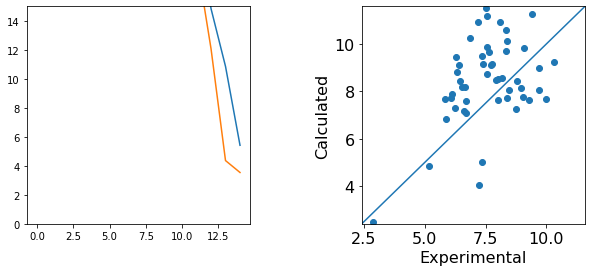

rmse: 1.882, mae: 1.611, r2: 0.440, rho: 0.288


4gfm,7.220,3.159


Epoch: 14	Lapse: 4.8s	Losses: (5.417, 3.540)	Best: (5.417, 3.540)
Epoch: 15	Lapse: 5.1s	Losses: (5.688, 5.173)	Best: (5.417, 3.540)


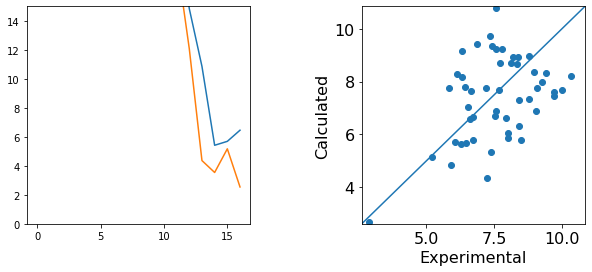

rmse: 1.594, mae: 1.345, r2: 0.420, rho: 0.278


4gfm,7.220,2.868
2yix,8.480,2.677


Epoch: 16	Lapse: 5.0s	Losses: (6.456, 2.540)	Best: (5.417, 2.540)
Epoch: 17	Lapse: 5.2s	Losses: (5.798, 2.760)	Best: (5.417, 2.540)


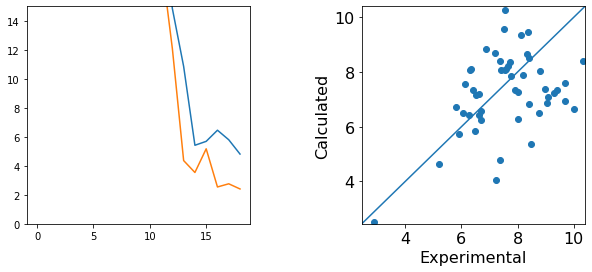

rmse: 1.550, mae: 1.255, r2: 0.406, rho: 0.258


4ivc,10.000,3.337
4gfm,7.220,3.167
2yix,8.480,3.123
4fk6,9.700,2.757
6g37,7.370,2.598


Epoch: 18	Lapse: 4.9s	Losses: (4.812, 2.404)	Best: (4.812, 2.404)


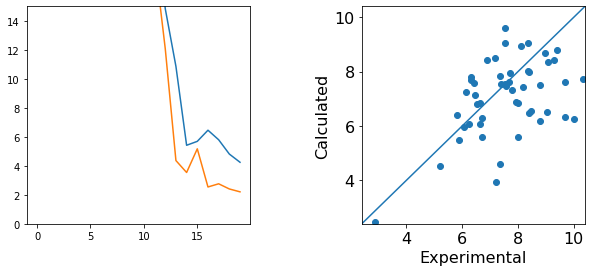

rmse: 1.485, mae: 1.136, r2: 0.483, rho: 0.368


4ivc,10.000,3.749
4fk6,9.700,3.381
4gfm,7.220,3.295
6g37,7.370,2.768
5wal,8.770,2.579
5h8g,10.320,2.577
4uja,9.050,2.552


Epoch: 19	Lapse: 5.0s	Losses: (4.245, 2.205)	Best: (4.245, 2.205)
Epoch: 20	Lapse: 5.4s	Losses: (4.237, 3.105)	Best: (4.237, 2.205)
Epoch: 21	Lapse: 5.2s	Losses: (3.820, 2.930)	Best: (3.820, 2.205)
Epoch: 22	Lapse: 5.0s	Losses: (4.223, 2.451)	Best: (3.820, 2.205)


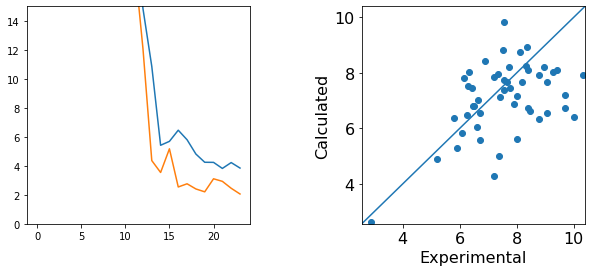

rmse: 1.434, mae: 1.112, r2: 0.479, rho: 0.346


4ivc,10.000,3.597
4fk6,9.700,2.960
4gfm,7.220,2.946


Epoch: 23	Lapse: 5.8s	Losses: (3.846, 2.056)	Best: (3.820, 2.056)


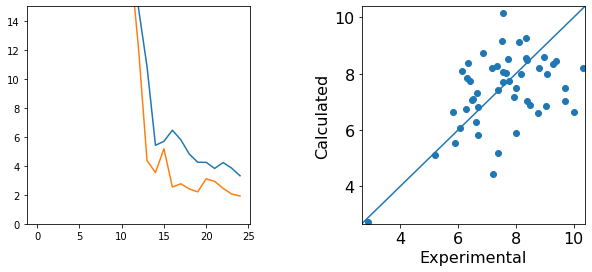

rmse: 1.385, mae: 1.085, r2: 0.481, rho: 0.343


4ivc,10.000,3.350
4gfm,7.220,2.794
4fk6,9.700,2.678


Epoch: 24	Lapse: 5.4s	Losses: (3.313, 1.919)	Best: (3.313, 1.919)


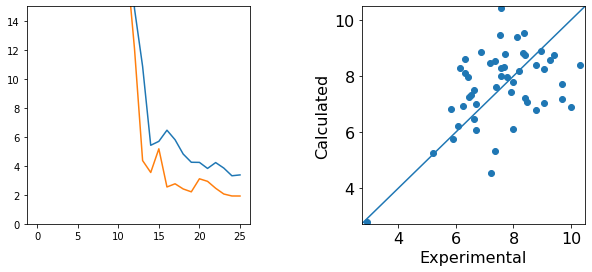

rmse: 1.385, mae: 1.106, r2: 0.485, rho: 0.347


4ivc,10.000,3.093
4gfm,7.220,2.690
4fk6,9.700,2.516


Epoch: 25	Lapse: 5.5s	Losses: (3.372, 1.917)	Best: (3.313, 1.917)
Epoch: 26	Lapse: 4.9s	Losses: (3.725, 1.933)	Best: (3.313, 1.917)
Epoch: 27	Lapse: 5.5s	Losses: (3.451, 2.071)	Best: (3.313, 1.917)
Epoch: 28	Lapse: 5.1s	Losses: (3.304, 2.184)	Best: (3.304, 1.917)
Epoch: 29	Lapse: 5.9s	Losses: (4.220, 2.044)	Best: (3.304, 1.917)
Epoch: 30	Lapse: 5.6s	Losses: (3.263, 2.210)	Best: (3.263, 1.917)
Epoch: 31	Lapse: 5.7s	Losses: (3.861, 2.089)	Best: (3.263, 1.917)
Epoch: 32	Lapse: 5.0s	Losses: (3.296, 2.038)	Best: (3.263, 1.917)
Epoch: 33	Lapse: 5.7s	Losses: (3.551, 2.010)	Best: (3.263, 1.917)
Epoch: 34	Lapse: 6.4s	Losses: (3.782, 1.980)	Best: (3.263, 1.917)
Epoch: 35	Lapse: 5.5s	Losses: (3.959, 2.036)	Best: (3.263, 1.917)
Epoch: 36	Lapse: 5.0s	Losses: (3.136, 2.079)	Best: (3.136, 1.917)
Epoch: 37	Lapse: 5.3s	Losses: (2.966, 2.180)	Best: (2.966, 1.917)
Epoch: 38	Lapse: 5.0s	Losses: (4.342, 2.232)	Best: (2.966, 1.917)
Epoch: 39	Lapse: 4.9s	Losses: (3.178, 2.095)	Best: (2.966, 1.917)
Epoch: 40	

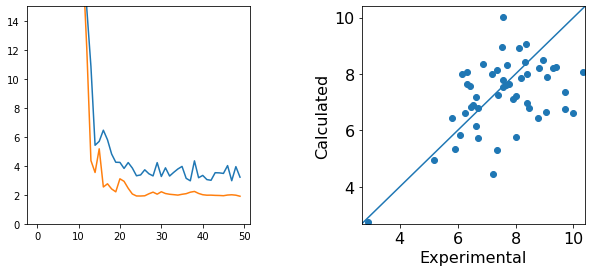

rmse: 1.379, mae: 1.067, r2: 0.494, rho: 0.363


4ivc,10.000,3.388
4fk6,9.700,2.958
4gfm,7.220,2.774


Epoch: 49	Lapse: 5.5s	Losses: (3.218, 1.901)	Best: (2.966, 1.901)


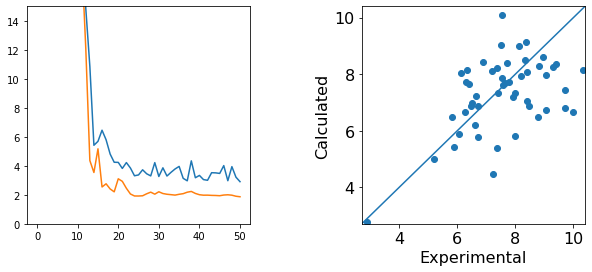

rmse: 1.366, mae: 1.058, r2: 0.496, rho: 0.367


4ivc,10.000,3.321
4fk6,9.700,2.895
4gfm,7.220,2.741


Epoch: 50	Lapse: 5.4s	Losses: (2.906, 1.866)	Best: (2.906, 1.866)


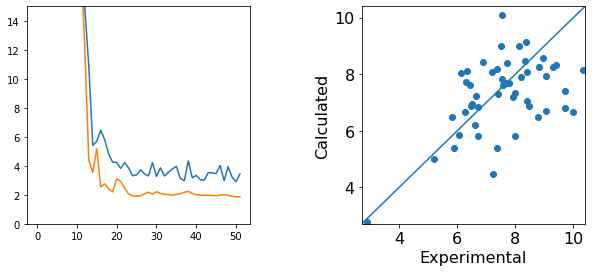

rmse: 1.365, mae: 1.056, r2: 0.498, rho: 0.374


4ivc,10.000,3.327
4fk6,9.700,2.903
4gfm,7.220,2.754


Epoch: 51	Lapse: 5.2s	Losses: (3.441, 1.863)	Best: (2.906, 1.863)


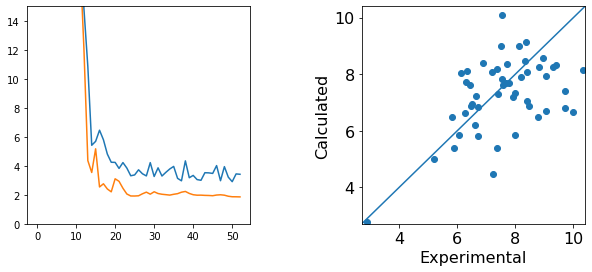

rmse: 1.362, mae: 1.053, r2: 0.499, rho: 0.374


4ivc,10.000,3.323
4fk6,9.700,2.897
4gfm,7.220,2.751


Epoch: 52	Lapse: 4.7s	Losses: (3.416, 1.856)	Best: (2.906, 1.856)
Epoch: 53	Lapse: 5.7s	Losses: (3.078, 1.859)	Best: (2.906, 1.856)
Epoch: 54	Lapse: 5.4s	Losses: (3.290, 1.873)	Best: (2.906, 1.856)
Epoch: 55	Lapse: 4.9s	Losses: (3.122, 1.915)	Best: (2.906, 1.856)
Epoch: 56	Lapse: 5.0s	Losses: (2.900, 2.047)	Best: (2.900, 1.856)
Epoch: 57	Lapse: 5.5s	Losses: (3.487, 2.192)	Best: (2.900, 1.856)
Epoch: 58	Lapse: 4.9s	Losses: (3.183, 2.236)	Best: (2.900, 1.856)
Epoch: 59	Lapse: 5.5s	Losses: (3.901, 2.207)	Best: (2.900, 1.856)
Epoch: 60	Lapse: 5.5s	Losses: (3.025, 2.081)	Best: (2.900, 1.856)
Epoch: 61	Lapse: 4.9s	Losses: (2.785, 1.903)	Best: (2.785, 1.856)


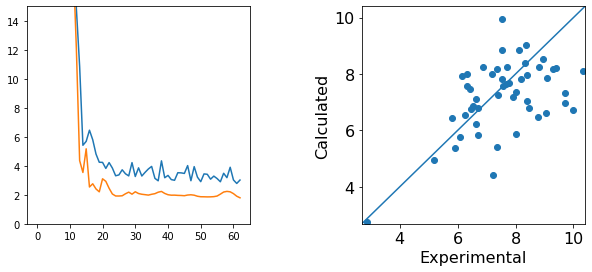

rmse: 1.339, mae: 1.029, r2: 0.518, rho: 0.399


4ivc,10.000,3.277
4gfm,7.220,2.781
4fk6,9.700,2.725


Epoch: 62	Lapse: 4.9s	Losses: (3.019, 1.793)	Best: (2.785, 1.793)


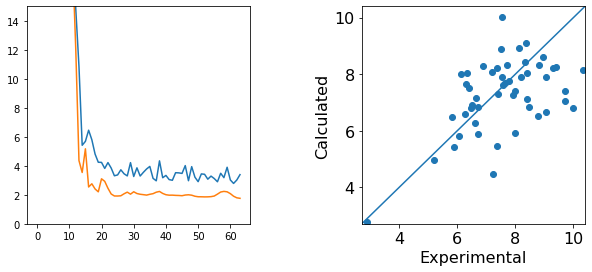

rmse: 1.326, mae: 1.022, r2: 0.520, rho: 0.396


4ivc,10.000,3.210
4gfm,7.220,2.746
4fk6,9.700,2.650


Epoch: 63	Lapse: 5.6s	Losses: (3.391, 1.758)	Best: (2.785, 1.758)
Epoch: 64	Lapse: 5.0s	Losses: (3.556, 1.766)	Best: (2.785, 1.758)
Epoch: 65	Lapse: 5.2s	Losses: (3.829, 1.838)	Best: (2.785, 1.758)
Epoch: 66	Lapse: 5.2s	Losses: (2.944, 1.937)	Best: (2.785, 1.758)
Epoch: 67	Lapse: 4.9s	Losses: (3.647, 2.005)	Best: (2.785, 1.758)
Epoch: 68	Lapse: 4.9s	Losses: (3.008, 2.037)	Best: (2.785, 1.758)
Epoch: 69	Lapse: 5.4s	Losses: (2.876, 2.184)	Best: (2.785, 1.758)
Epoch: 70	Lapse: 4.9s	Losses: (2.531, 2.210)	Best: (2.531, 1.758)
Epoch: 71	Lapse: 5.4s	Losses: (3.139, 2.040)	Best: (2.531, 1.758)
Epoch: 72	Lapse: 5.6s	Losses: (3.340, 1.954)	Best: (2.531, 1.758)
Epoch: 73	Lapse: 6.1s	Losses: (3.387, 1.888)	Best: (2.531, 1.758)
Epoch: 74	Lapse: 9190.7s	Losses: (3.057, 1.867)	Best: (2.531, 1.758)
Epoch: 75	Lapse: 5.7s	Losses: (2.577, 1.895)	Best: (2.531, 1.758)
Epoch: 76	Lapse: 5.0s	Losses: (3.060, 1.903)	Best: (2.531, 1.758)
Epoch: 77	Lapse: 5.3s	Losses: (2.161, 1.879)	Best: (2.161, 1.758)
Epoch: 

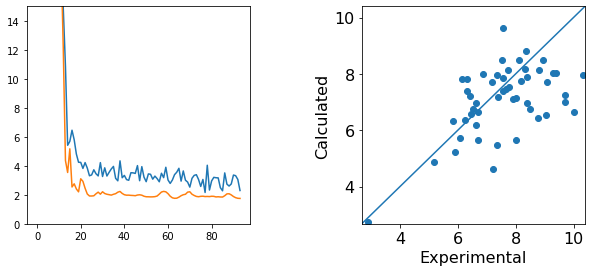

rmse: 1.323, mae: 1.011, r2: 0.546, rho: 0.429


4ivc,10.000,3.345
4fk6,9.700,2.708
4gfm,7.220,2.605
4uja,9.050,2.505


Epoch: 93	Lapse: 5.1s	Losses: (2.296, 1.751)	Best: (2.161, 1.751)
Epoch: 94	Lapse: 4.9s	Losses: (3.122, 1.838)	Best: (2.161, 1.751)
Epoch: 95	Lapse: 5.1s	Losses: (2.550, 2.111)	Best: (2.161, 1.751)
Epoch: 96	Lapse: 5.0s	Losses: (2.672, 2.142)	Best: (2.161, 1.751)
Epoch: 97	Lapse: 4.8s	Losses: (2.481, 1.908)	Best: (2.161, 1.751)


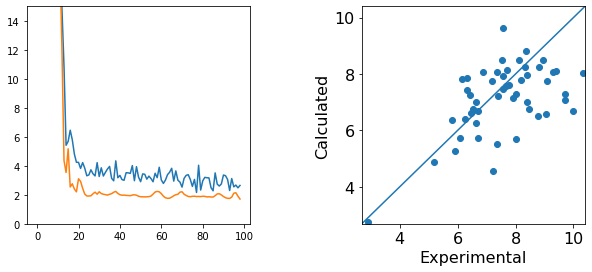

rmse: 1.307, mae: 0.994, r2: 0.550, rho: 0.432


4ivc,10.000,3.321
4gfm,7.220,2.656
4fk6,9.700,2.622


Epoch: 98	Lapse: 4.7s	Losses: (2.647, 1.709)	Best: (2.161, 1.709)


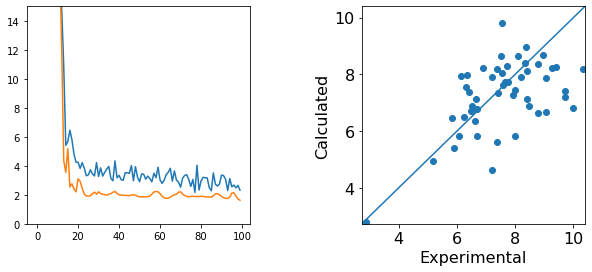

rmse: 1.274, mae: 0.971, r2: 0.552, rho: 0.432


4ivc,10.000,3.197
4gfm,7.220,2.581


Epoch: 99	Lapse: 5.4s	Losses: (2.328, 1.623)	Best: (2.161, 1.623)
Epoch: 100	Lapse: 5.0s	Losses: (2.606, 1.642)	Best: (2.161, 1.623)
Epoch: 101	Lapse: 4.9s	Losses: (2.528, 1.682)	Best: (2.161, 1.623)
Epoch: 102	Lapse: 5.0s	Losses: (3.057, 1.846)	Best: (2.161, 1.623)
Epoch: 103	Lapse: 5.5s	Losses: (3.309, 2.031)	Best: (2.161, 1.623)
Epoch: 104	Lapse: 5.0s	Losses: (2.665, 2.127)	Best: (2.161, 1.623)
Epoch: 105	Lapse: 5.4s	Losses: (2.345, 2.090)	Best: (2.161, 1.623)
Epoch: 106	Lapse: 5.2s	Losses: (2.551, 1.972)	Best: (2.161, 1.623)
Epoch: 107	Lapse: 5.5s	Losses: (3.341, 1.815)	Best: (2.161, 1.623)
Epoch: 108	Lapse: 5.1s	Losses: (2.683, 1.684)	Best: (2.161, 1.623)


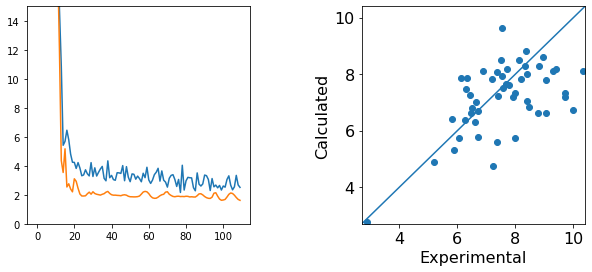

rmse: 1.273, mae: 0.964, r2: 0.563, rho: 0.441


4ivc,10.000,3.274


Epoch: 109	Lapse: 5.6s	Losses: (2.513, 1.620)	Best: (2.161, 1.620)
Epoch: 110	Lapse: 5.2s	Losses: (2.600, 1.678)	Best: (2.161, 1.620)
Epoch: 111	Lapse: 5.5s	Losses: (2.968, 1.857)	Best: (2.161, 1.620)
Epoch: 112	Lapse: 5.4s	Losses: (2.812, 2.131)	Best: (2.161, 1.620)
Epoch: 113	Lapse: 5.3s	Losses: (2.621, 2.051)	Best: (2.161, 1.620)
Epoch: 114	Lapse: 4.9s	Losses: (2.471, 1.832)	Best: (2.161, 1.620)
Epoch: 115	Lapse: 5.5s	Losses: (2.971, 1.677)	Best: (2.161, 1.620)
Epoch: 116	Lapse: 4.9s	Losses: (3.359, 1.724)	Best: (2.161, 1.620)
Epoch: 117	Lapse: 5.6s	Losses: (2.898, 1.909)	Best: (2.161, 1.620)
Epoch: 118	Lapse: 5.5s	Losses: (2.819, 1.973)	Best: (2.161, 1.620)
Epoch: 119	Lapse: 4.9s	Losses: (2.577, 1.845)	Best: (2.161, 1.620)
Epoch: 120	Lapse: 4.8s	Losses: (2.535, 1.830)	Best: (2.161, 1.620)
Epoch: 121	Lapse: 5.8s	Losses: (2.640, 1.845)	Best: (2.161, 1.620)
Epoch: 122	Lapse: 5.2s	Losses: (2.475, 1.766)	Best: (2.161, 1.620)
Epoch: 123	Lapse: 4.9s	Losses: (2.319, 1.708)	Best: (2.161, 1.

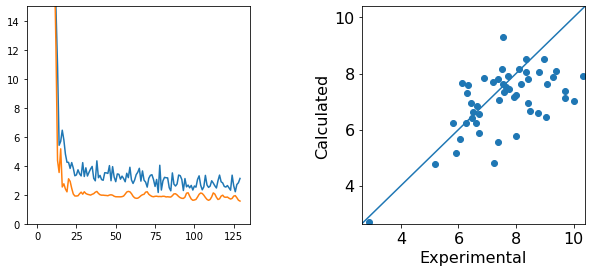

rmse: 1.252, mae: 0.941, r2: 0.610, rho: 0.496


4ivc,10.000,2.989
4uja,9.050,2.605
5dxt,9.700,2.556


Epoch: 129	Lapse: 5.1s	Losses: (3.129, 1.568)	Best: (2.161, 1.568)
Epoch: 130	Lapse: 5.3s	Losses: (2.882, 1.652)	Best: (2.161, 1.568)
Epoch: 131	Lapse: 4.9s	Losses: (3.166, 1.691)	Best: (2.161, 1.568)
Epoch: 132	Lapse: 5.2s	Losses: (2.639, 1.828)	Best: (2.161, 1.568)
Epoch: 133	Lapse: 5.0s	Losses: (2.377, 1.863)	Best: (2.161, 1.568)
Epoch: 134	Lapse: 5.5s	Losses: (2.997, 1.858)	Best: (2.161, 1.568)
Epoch: 135	Lapse: 5.1s	Losses: (2.258, 1.821)	Best: (2.161, 1.568)
Epoch: 136	Lapse: 5.5s	Losses: (2.903, 1.707)	Best: (2.161, 1.568)
Epoch: 137	Lapse: 5.0s	Losses: (2.249, 1.629)	Best: (2.161, 1.568)
Epoch: 138	Lapse: 5.0s	Losses: (2.651, 1.579)	Best: (2.161, 1.568)


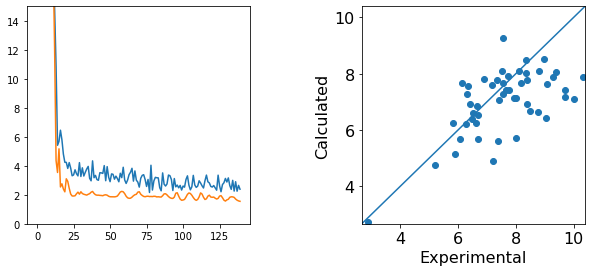

rmse: 1.246, mae: 0.942, r2: 0.618, rho: 0.509


4ivc,10.000,2.896
4uja,9.050,2.626
5dxt,9.700,2.538


Epoch: 139	Lapse: 5.9s	Losses: (2.387, 1.552)	Best: (2.161, 1.552)
Epoch: 140	Lapse: 4.8s	Losses: (2.676, 1.617)	Best: (2.161, 1.552)
Epoch: 141	Lapse: 5.6s	Losses: (3.320, 1.588)	Best: (2.161, 1.552)


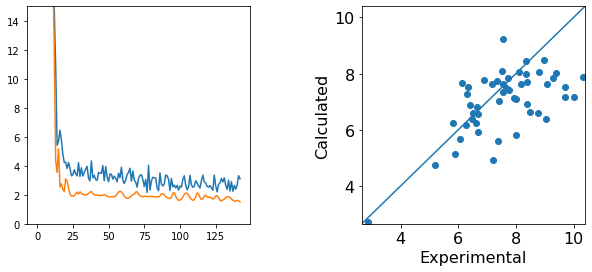

rmse: 1.233, mae: 0.930, r2: 0.627, rho: 0.522


4ivc,10.000,2.813
4uja,9.050,2.647
5dxt,9.700,2.548


Epoch: 142	Lapse: 5.2s	Losses: (3.111, 1.520)	Best: (2.161, 1.520)


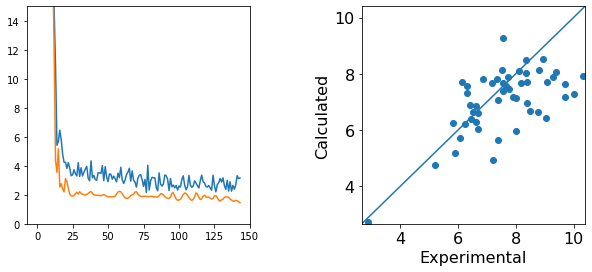

rmse: 1.206, mae: 0.908, r2: 0.632, rho: 0.526


4ivc,10.000,2.721
4uja,9.050,2.608
5dxt,9.700,2.508


Epoch: 143	Lapse: 4.9s	Losses: (3.160, 1.456)	Best: (2.161, 1.456)


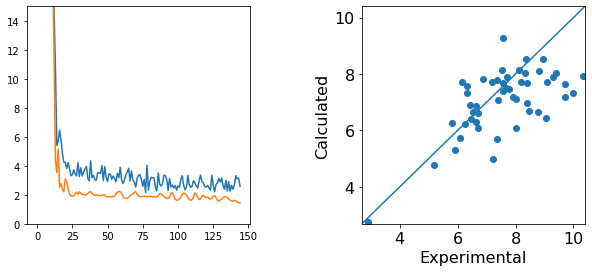

rmse: 1.199, mae: 0.904, r2: 0.633, rho: 0.518


4ivc,10.000,2.679
4uja,9.050,2.610
5dxt,9.700,2.502


Epoch: 144	Lapse: 5.9s	Losses: (2.591, 1.438)	Best: (2.161, 1.438)
Epoch: 145	Lapse: 5.1s	Losses: (2.646, 1.482)	Best: (2.161, 1.438)
Epoch: 146	Lapse: 5.8s	Losses: (3.028, 1.668)	Best: (2.161, 1.438)
Epoch: 147	Lapse: 5.7s	Losses: (2.380, 1.914)	Best: (2.161, 1.438)
Epoch: 148	Lapse: 5.6s	Losses: (2.612, 2.100)	Best: (2.161, 1.438)
Epoch: 149	Lapse: 5.7s	Losses: (3.058, 1.773)	Best: (2.161, 1.438)
Epoch: 150	Lapse: 5.1s	Losses: (2.416, 1.458)	Best: (2.161, 1.438)


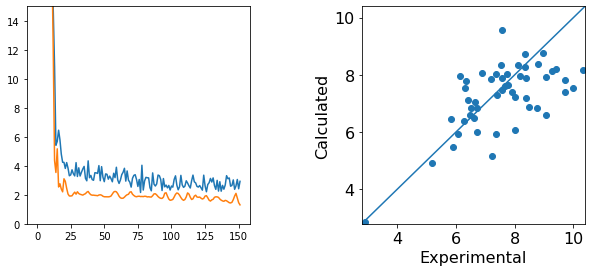

rmse: 1.143, mae: 0.868, r2: 0.630, rho: 0.519


Epoch: 151	Lapse: 6.2s	Losses: (2.930, 1.307)	Best: (2.161, 1.307)
Epoch: 152	Lapse: 5.7s	Losses: (2.534, 1.393)	Best: (2.161, 1.307)
Epoch: 153	Lapse: 5.1s	Losses: (2.620, 1.688)	Best: (2.161, 1.307)
Epoch: 154	Lapse: 5.2s	Losses: (2.753, 1.854)	Best: (2.161, 1.307)
Epoch: 155	Lapse: 5.9s	Losses: (2.472, 1.665)	Best: (2.161, 1.307)
Epoch: 156	Lapse: 5.5s	Losses: (2.451, 1.382)	Best: (2.161, 1.307)
Epoch: 157	Lapse: 6.0s	Losses: (2.382, 1.309)	Best: (2.161, 1.307)
Epoch: 158	Lapse: 6.1s	Losses: (2.442, 1.368)	Best: (2.161, 1.307)
Epoch: 159	Lapse: 5.2s	Losses: (2.455, 1.544)	Best: (2.161, 1.307)
Epoch: 160	Lapse: 5.2s	Losses: (2.559, 1.623)	Best: (2.161, 1.307)
Epoch: 161	Lapse: 6.1s	Losses: (2.176, 1.580)	Best: (2.161, 1.307)
Epoch: 162	Lapse: 5.3s	Losses: (2.271, 1.514)	Best: (2.161, 1.307)
Epoch: 163	Lapse: 5.4s	Losses: (2.735, 1.332)	Best: (2.161, 1.307)
Epoch: 164	Lapse: 5.8s	Losses: (2.639, 1.316)	Best: (2.161, 1.307)
Epoch: 165	Lapse: 5.4s	Losses: (3.212, 1.421)	Best: (2.161, 1.

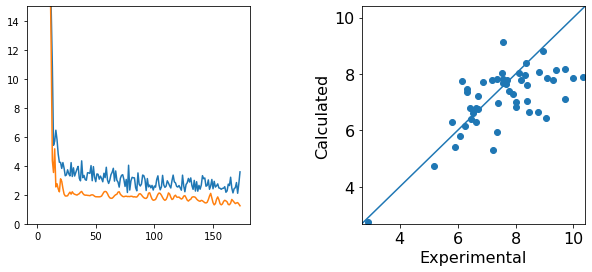

rmse: 1.115, mae: 0.837, r2: 0.672, rho: 0.597


4uja,9.050,2.623
5dxt,9.700,2.576


Epoch: 173	Lapse: 5.7s	Losses: (3.581, 1.243)	Best: (2.105, 1.243)
Epoch: 174	Lapse: 6.3s	Losses: (2.641, 1.328)	Best: (2.105, 1.243)
Epoch: 175	Lapse: 6.2s	Losses: (2.447, 1.624)	Best: (2.105, 1.243)
Epoch: 176	Lapse: 5.6s	Losses: (2.622, 1.975)	Best: (2.105, 1.243)
Epoch: 177	Lapse: 5.9s	Losses: (2.242, 1.839)	Best: (2.105, 1.243)
Epoch: 178	Lapse: 7.9s	Losses: (2.097, 1.502)	Best: (2.097, 1.243)
Epoch: 179	Lapse: 8.6s	Losses: (2.217, 1.268)	Best: (2.097, 1.243)


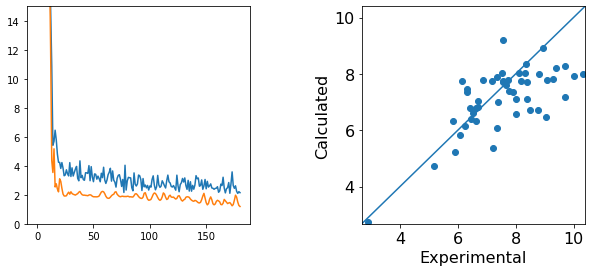

rmse: 1.093, mae: 0.822, r2: 0.685, rho: 0.599


4uja,9.050,2.588
5dxt,9.700,2.530


Epoch: 180	Lapse: 9.5s	Losses: (2.147, 1.195)	Best: (2.097, 1.195)
Epoch: 181	Lapse: 9.6s	Losses: (3.147, 1.399)	Best: (2.097, 1.195)
Epoch: 182	Lapse: 9.2s	Losses: (2.317, 1.843)	Best: (2.097, 1.195)
Epoch: 183	Lapse: 9.1s	Losses: (1.885, 1.801)	Best: (1.885, 1.195)
Epoch: 184	Lapse: 9.3s	Losses: (2.267, 1.480)	Best: (1.885, 1.195)
Epoch: 185	Lapse: 10.0s	Losses: (2.479, 1.288)	Best: (1.885, 1.195)


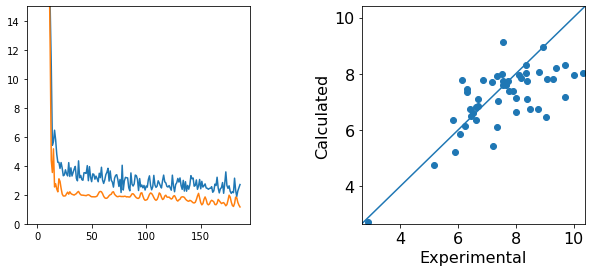

rmse: 1.078, mae: 0.807, r2: 0.692, rho: 0.605


4uja,9.050,2.589
5dxt,9.700,2.524


Epoch: 186	Lapse: 9.6s	Losses: (2.708, 1.162)	Best: (1.885, 1.162)
Epoch: 187	Lapse: 9.5s	Losses: (2.683, 1.214)	Best: (1.885, 1.162)
Epoch: 188	Lapse: 9.8s	Losses: (2.326, 1.449)	Best: (1.885, 1.162)
Epoch: 189	Lapse: 9.7s	Losses: (2.349, 1.541)	Best: (1.885, 1.162)
Epoch: 190	Lapse: 9.7s	Losses: (1.947, 1.569)	Best: (1.885, 1.162)
Epoch: 191	Lapse: 10.0s	Losses: (1.934, 1.393)	Best: (1.885, 1.162)
Epoch: 192	Lapse: 9.8s	Losses: (2.370, 1.263)	Best: (1.885, 1.162)
Epoch: 193	Lapse: 10.0s	Losses: (2.730, 1.261)	Best: (1.885, 1.162)
Epoch: 194	Lapse: 10.2s	Losses: (2.100, 1.399)	Best: (1.885, 1.162)
Epoch: 195	Lapse: 10.0s	Losses: (2.019, 1.562)	Best: (1.885, 1.162)
Epoch: 196	Lapse: 9.9s	Losses: (2.150, 1.537)	Best: (1.885, 1.162)
Epoch: 197	Lapse: 10.1s	Losses: (2.272, 1.385)	Best: (1.885, 1.162)
Epoch: 198	Lapse: 9.9s	Losses: (2.012, 1.331)	Best: (1.885, 1.162)
Epoch: 199	Lapse: 9.9s	Losses: (3.284, 1.498)	Best: (1.885, 1.162)
Epoch: 200	Lapse: 10.4s	Losses: (1.775, 1.475)	Best: (1.7

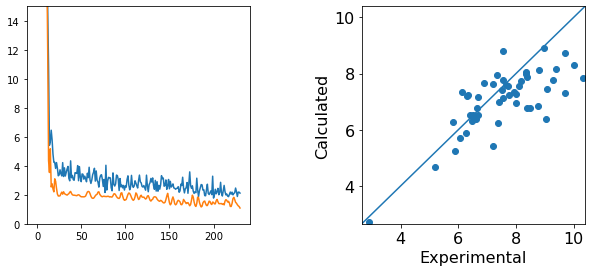

rmse: 1.043, mae: 0.795, r2: 0.742, rho: 0.654


4uja,9.050,2.660


Epoch: 230	Lapse: 10.2s	Losses: (2.118, 1.089)	Best: (1.775, 1.089)
Epoch: 231	Lapse: 10.3s	Losses: (1.815, 1.199)	Best: (1.775, 1.089)
Epoch: 232	Lapse: 10.3s	Losses: (1.826, 1.581)	Best: (1.775, 1.089)
Epoch: 233	Lapse: 11.0s	Losses: (2.204, 1.790)	Best: (1.775, 1.089)
Epoch: 234	Lapse: 10.6s	Losses: (2.497, 1.774)	Best: (1.775, 1.089)
Epoch: 235	Lapse: 10.5s	Losses: (2.097, 1.531)	Best: (1.775, 1.089)
Epoch: 236	Lapse: 10.6s	Losses: (2.252, 1.284)	Best: (1.775, 1.089)
Epoch: 237	Lapse: 10.5s	Losses: (1.730, 1.358)	Best: (1.730, 1.089)
Epoch: 238	Lapse: 10.1s	Losses: (1.992, 1.552)	Best: (1.730, 1.089)
Epoch: 239	Lapse: 10.4s	Losses: (2.438, 1.280)	Best: (1.730, 1.089)


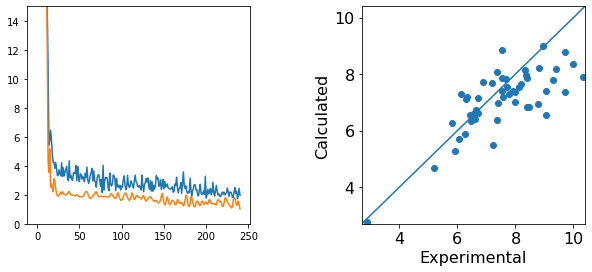

rmse: 1.015, mae: 0.778, r2: 0.751, rho: 0.664


Epoch: 240	Lapse: 10.5s	Losses: (1.961, 1.030)	Best: (1.730, 1.030)
Epoch: 241	Lapse: 10.2s	Losses: (2.189, 1.244)	Best: (1.730, 1.030)
Epoch: 242	Lapse: 10.8s	Losses: (2.183, 1.914)	Best: (1.730, 1.030)
Epoch: 243	Lapse: 10.5s	Losses: (1.804, 1.864)	Best: (1.730, 1.030)
Epoch: 244	Lapse: 10.4s	Losses: (2.172, 1.537)	Best: (1.730, 1.030)
Epoch: 245	Lapse: 10.8s	Losses: (2.353, 1.133)	Best: (1.730, 1.030)


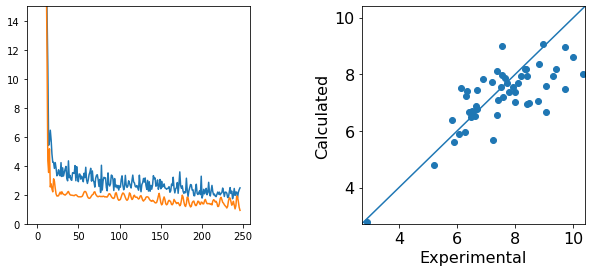

rmse: 0.963, mae: 0.727, r2: 0.750, rho: 0.656


Epoch: 246	Lapse: 10.9s	Losses: (2.478, 0.928)	Best: (1.730, 0.928)
Epoch: 247	Lapse: 10.2s	Losses: (2.127, 1.013)	Best: (1.730, 0.928)
Epoch: 248	Lapse: 10.8s	Losses: (2.118, 1.348)	Best: (1.730, 0.928)
Epoch: 249	Lapse: 10.3s	Losses: (1.603, 1.721)	Best: (1.603, 0.928)
Epoch: 250	Lapse: 10.3s	Losses: (2.139, 1.685)	Best: (1.603, 0.928)
Epoch: 251	Lapse: 10.5s	Losses: (2.169, 1.384)	Best: (1.603, 0.928)
Epoch: 252	Lapse: 10.2s	Losses: (1.976, 1.108)	Best: (1.603, 0.928)
Epoch: 253	Lapse: 10.4s	Losses: (1.868, 0.986)	Best: (1.603, 0.928)
Epoch: 254	Lapse: 10.7s	Losses: (2.225, 1.185)	Best: (1.603, 0.928)
Epoch: 255	Lapse: 10.7s	Losses: (1.818, 1.555)	Best: (1.603, 0.928)
Epoch: 256	Lapse: 10.6s	Losses: (2.343, 1.882)	Best: (1.603, 0.928)
Epoch: 257	Lapse: 10.4s	Losses: (1.991, 1.892)	Best: (1.603, 0.928)
Epoch: 258	Lapse: 10.6s	Losses: (1.818, 1.562)	Best: (1.603, 0.928)
Epoch: 259	Lapse: 10.4s	Losses: (2.017, 1.191)	Best: (1.603, 0.928)
Epoch: 260	Lapse: 10.4s	Losses: (2.127, 1.184)	B

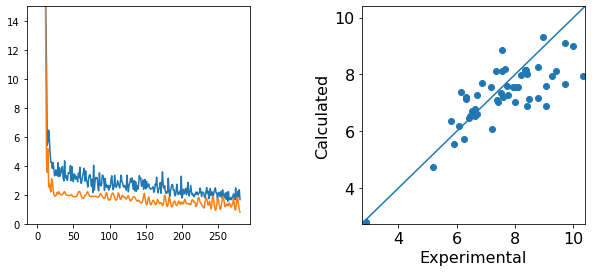

rmse: 0.899, mae: 0.690, r2: 0.787, rho: 0.691


Epoch: 280	Lapse: 10.1s	Losses: (1.670, 0.808)	Best: (1.556, 0.808)
Epoch: 281	Lapse: 10.5s	Losses: (2.160, 1.009)	Best: (1.556, 0.808)
Epoch: 282	Lapse: 10.7s	Losses: (1.927, 1.443)	Best: (1.556, 0.808)
Epoch: 283	Lapse: 10.8s	Losses: (1.771, 1.405)	Best: (1.556, 0.808)
Epoch: 284	Lapse: 10.6s	Losses: (1.978, 1.185)	Best: (1.556, 0.808)
Epoch: 285	Lapse: 10.3s	Losses: (1.910, 1.114)	Best: (1.556, 0.808)
Epoch: 286	Lapse: 10.8s	Losses: (2.088, 1.046)	Best: (1.556, 0.808)
Epoch: 287	Lapse: 10.3s	Losses: (1.718, 1.148)	Best: (1.556, 0.808)
Epoch: 288	Lapse: 10.9s	Losses: (1.604, 1.295)	Best: (1.556, 0.808)
Epoch: 289	Lapse: 10.4s	Losses: (2.329, 1.274)	Best: (1.556, 0.808)
Epoch: 290	Lapse: 10.4s	Losses: (1.842, 1.319)	Best: (1.556, 0.808)
Epoch: 291	Lapse: 10.6s	Losses: (2.080, 1.105)	Best: (1.556, 0.808)
Epoch: 292	Lapse: 10.2s	Losses: (1.889, 0.855)	Best: (1.556, 0.808)
Epoch: 293	Lapse: 11.4s	Losses: (1.769, 1.014)	Best: (1.556, 0.808)
Epoch: 294	Lapse: 10.9s	Losses: (1.695, 1.521)	B

Epoch: 401	Lapse: 11.0s	Losses: (1.625, 1.771)	Best: (1.242, 0.808)
Epoch: 402	Lapse: 11.0s	Losses: (1.507, 1.174)	Best: (1.242, 0.808)
Epoch: 403	Lapse: 11.4s	Losses: (2.250, 1.123)	Best: (1.242, 0.808)
Epoch: 404	Lapse: 11.2s	Losses: (1.407, 1.875)	Best: (1.242, 0.808)
Epoch: 405	Lapse: 11.2s	Losses: (1.389, 2.223)	Best: (1.242, 0.808)
Epoch: 406	Lapse: 11.4s	Losses: (1.835, 1.789)	Best: (1.242, 0.808)
Epoch: 407	Lapse: 11.2s	Losses: (1.691, 0.860)	Best: (1.242, 0.808)


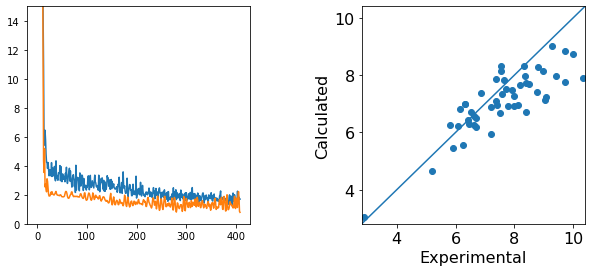

rmse: 0.890, mae: 0.700, r2: 0.838, rho: 0.782


Epoch: 408	Lapse: 11.5s	Losses: (1.700, 0.791)	Best: (1.242, 0.791)
Epoch: 409	Lapse: 11.1s	Losses: (1.740, 1.603)	Best: (1.242, 0.791)


In [ ]:
CLEAR_OUTPUT_WHEN_UPDATE = False
SHOW_VERY_BAD_MOLS = True

best_train_loss, best_val_loss = np.inf, np.inf
Los = []
Lps = []

for epoch in range(learn_opts.num_epochs):
    st = time.time()
    train_losses, test_losses = [], []

    model.train()
    train_loss = learn(model, train_dataloader)
    Los.append(train_loss)

    model.eval()
    test_loss = learn(model, test_dataloader, train=False)
    Lps.append(test_loss)

    lapse = time.time() - st

    best_train_loss = update_train_loss(train_loss, best_train_loss)
    best_val_loss, output = update_test_loss(model, myopts, test_loss, best_val_loss, epoch)

    if output:
        X, y, L, S, N = test(model, test_dataloader)
        write_results_to_csv(L[0], X, y, np.abs(X-y), epoch)

        rmse, mae, r2, rho = get_stats(X, y)
        if CLEAR_OUTPUT_WHEN_UPDATE:
            clear_output()
        myplot(X, y, Los, Lps)
        print(f'rmse: {rmse:5.3f}, mae: {mae:5.3f}, r2: {r2:5.3f}, rho: {rho:5.3f}')
        if SHOW_VERY_BAD_MOLS:
            show_bad_molecules(L, X, y, np.abs(X-y), len(X))

    ls = [f'Epoch: {epoch}',
          f'Lapse: {lapse:.1f}s',
          f'Losses: ({train_loss:.3f}, {test_loss:.3f})',
          f'Best: ({best_train_loss:.3f}, {best_val_loss:.3f})']
    print('\t'.join(ls))